<a href="https://colab.research.google.com/github/MHChe/BLISS/blob/main/train_drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Training a Neural Network for Sensor Drift Compensation
Goal: finding 2 key variables for modeling sensor drift <br>
Created: Ming-Hao Cheng <br>
Date: Sep. 08, 2022


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import io
from random import shuffle

In [55]:
data_upload = files.upload() # select data to upload

Saving training_examples_solution.xlsx to training_examples_solution (4).xlsx


(1) Data partition 

In [56]:
data_in = pd.read_excel(io.BytesIO(data_upload['training_examples_solution.xlsx']))
# data_in
sample_size = 18
num_sample = 449
ind_list = [i for i in range(num_sample)]
shuffle(ind_list)
# testCase_percent = 0.2
x_train = data_in.sample_data
y_train = np.array(data_in.time_constant[0:num_sample])
y_train = np.reshape(y_train,(num_sample,1))
Y_train = np.empty(np.shape(y_train))
# X_train = np.empty((num_sample,sample_size,1))
X = np.empty((num_sample,sample_size,1))
XX = np.empty((num_sample,sample_size,1))

# format data set
for i in range(len(y_train)):
# for i in range(1):
  x = np.array(x_train[sample_size*i:sample_size+sample_size*i])
  max_x = max(x)
  min_x = min(x)
  XX[i,:,0] = (x-min_x)/(max_x-min_x) # normalize
  # print(i,max_x-min_x)
  # XX[i,:,0] = x

# randomly shuffle data
for i in range(len(y_train)):
  X[i,:,0] = XX[ind_list[i],:,0]
  Y_train[i] = y_train[ind_list[i]]

X_train = X[0:350]
X_val = X[350:400]
y_val = Y_train[350:400]
y_test = Y_train[400:449]
Y_train = Y_train[0:350]
X_test = X[400:449]
# max_y = max(y_train)
# min_y = min(y_train)
# y_train = (y_train-min_y)/(max_y-min_y)
# print(max_x,min_x)
# print(np.shape(Y_train))
# print(np.shape(y_test))
# print(np.shape(X_train))
# print(np.shape(X_test))
# print(y_train[0])
# print(X_test)
# plt.plot(X_test[4])
# plt.show()
# X_train

(2) Building a neural network and train the algorithm

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# from tensorflow.keras import layers

# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(sample_size,1))
# model.add(tf.keras.layers.LSTM(40))
# model.add(tf.keras.layers.Dense(16, activation= tf.nn.relu))
# model.add(tf.keras.layers.Dense(8, activation= tf.nn.relu))
# # model.add(tf.keras.layers.Dense(6, activation= tf.nn.relu))
# # model.add(tf.keras.layers.Dense(9, activation= tf.nn.relu))
# model.add(tf.keras.layers.Dense(1))
model = Sequential([layers.Input((sample_size, 1)),
                    # layers.LSTM(32),
                    layers.Conv1D(filters = 16, kernel_size= 3, activation = 'relu'),
                    # layers.Dropout(0.2),
                    # layers.MaxPooling1D(pool_size=2,strides=1),
                    layers.Conv1D(filters = 32, kernel_size= 3, activation = 'relu'),
                    # layers.MaxPooling1D(pool_size=2,strides=1),
                    layers.Conv1D(filters = 64, kernel_size= 3, activation = 'relu'),
                    # layers.Conv1D(filters = 128, kernel_size= 3, activation = 'relu'),
                    # layers.MaxPooling1D(pool_size=2,strides=1),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    # layers.Dropout(0.2),
                    layers.Dense(64, activation='relu'),
                    # layers.Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    # layers.Dense(9, activation='tanh'),
                    # layers.Dense(9, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.summary()
# history = model.fit(X_train, y_train, epochs=1800)
history = model.fit(X_train, Y_train, validation_data = (X_val, y_val), epochs=1000)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 16, 16)            64        
                                                                 
 conv1d_34 (Conv1D)          (None, 14, 32)            1568      
                                                                 
 conv1d_35 (Conv1D)          (None, 12, 64)            6208      
                                                                 
 flatten_11 (Flatten)        (None, 768)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               98432     
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dense_46 (Dense)            (None, 32)              

(3) Visualizing the restuls

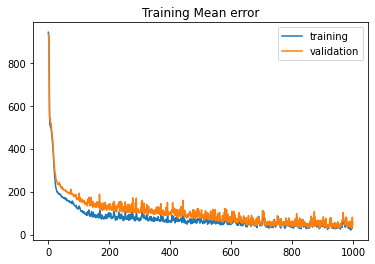

In [62]:
ME     = history.history['mean_absolute_error']
val_ME = history.history['val_mean_absolute_error']
epochs   = range(len(ME)) # Get number of epochs
plt.plot  (epochs, ME )
plt.plot  (epochs, val_ME )
plt.title ('Training Mean error'   )
plt.legend(['training','validation'])
plt.show()

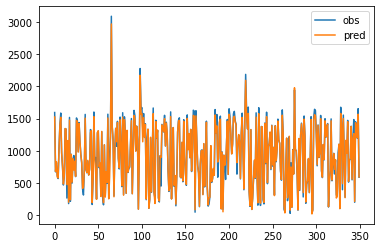

In [63]:
train_predictions  = model.predict(X_train)
test_predictions  = model.predict(X_test)
# print(train_predictions)
# print(test_predictions)
plt.plot(Y_train)
plt.plot(train_predictions)
plt.legend(['obs','pred'])

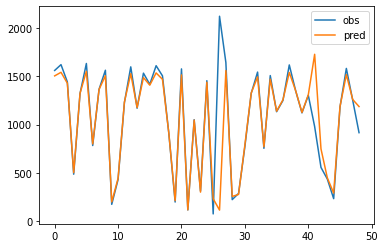

In [64]:
plt.plot(y_test)
plt.plot(test_predictions)
plt.legend(['obs','pred'])
# test_predictions